In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
mostRecent = session.query(Measurement).order_by(Measurement.date.desc()).first()
mostRecent.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x236c21cbe50>,
 'station': 'USC00519397',
 'id': 2724,
 'date': '2017-08-23',
 'tobs': 81.0,
 'prcp': 0.0}

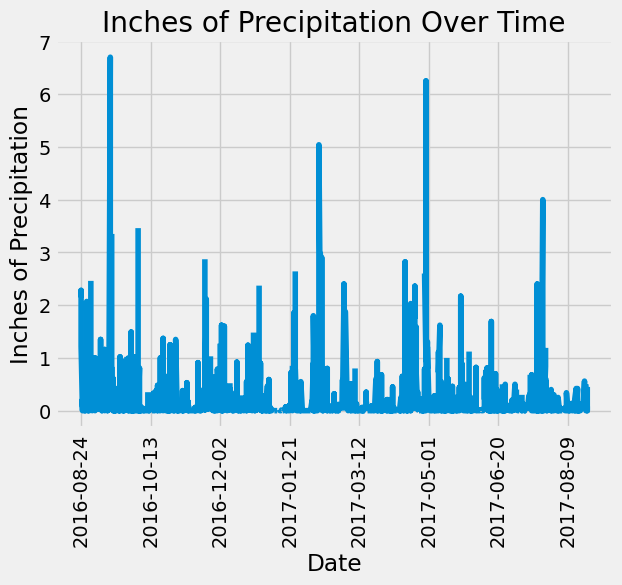

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostRecentDate = dt.datetime.strptime(mostRecent.date,'%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
oneYearPrior = mostRecentDate - dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
precipitationData = session.query(Measurement).\
    filter(Measurement.date.between(oneYearPrior,mostRecentDate))

# Save the query results as a Pandas DataFrame and set the index to the date column
pcDF = pd.read_sql(sql=precipitationData.statement,con=engine.connect(),index_col='date')

# Sort the dataframe by date
pcDF.sort_values('date',inplace=True)
pcDF.index= pd.to_datetime(pcDF.index).date

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(pcDF['prcp'])
plt.xlabel('Date')
plt.ylabel('Inches of Precipitation')
plt.title('Inches of Precipitation Over Time')
plt.xticks(np.arange(min(pcDF.index.values),max(pcDF.index.values),50),rotation=90)
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpAgg = pcDF.agg(['mean','median','var','std','sem'])['prcp']
prcpAgg

C:\Users\Frances Jay\AppData\Local\Temp\ipykernel_3708\2326205732.py:2: FutureWarning: ['station'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  prcpAgg = pcDF.agg(['mean','median','var','std','sem'])['prcp']


mean      0.176462
median    0.020000
var       0.211865
std       0.460288
sem       0.010254
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
stations = list(session.query(Station).group_by(Station.station))
for station in stations:
    print(station.station)

USC00511918
USC00513117
USC00514830
USC00516128
USC00517948
USC00518838
USC00519281
USC00519397
USC00519523


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stationlist={}

for stationX in stations:
    stationData = session.query(Measurement).filter(Measurement.station==stationX.station)
    stationActivity = stationData.count()
    stationlist[stationX.station]=stationActivity

stationSorted = dict(sorted(stationlist.items(),key=lambda item: item[1],reverse=True))
for x in stationSorted:
    print(x, stationSorted[x])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest,
# and average temperature.
mostActiveStation = list(stationSorted)[0]

stationData = session.query(Measurement).filter(Measurement.station==mostActiveStation)
stDF = pd.read_sql(sql=stationData.statement,con=engine.connect())

stAgg = stDF.agg(['min','max','mean'])['tobs']
stAgg

C:\Users\Frances Jay\AppData\Local\Temp\ipykernel_3708\3920514929.py:8: FutureWarning: ['station', 'date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stAgg = stDF.agg(['min','max','mean'])['tobs']


min     54.000000
max     85.000000
mean    71.663781
Name: tobs, dtype: float64

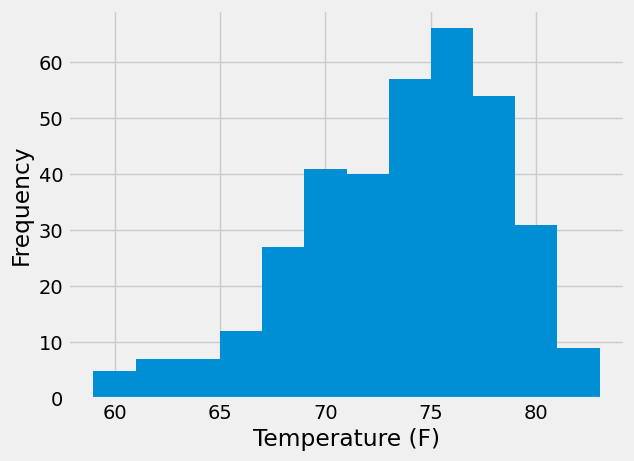

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostRecentDate = dt.datetime.strptime(stDF['date'].max(),'%Y-%m-%d').date()
oneYearPrior = mostRecentDate - dt.timedelta(weeks=52)
stationData = session.query(Measurement).filter(Measurement.station==mostActiveStation).filter(Measurement.date.between(oneYearPrior,mostRecentDate))
stDF = pd.read_sql(sql=stationData.statement,con=engine.connect())

n, bins, patches = plt.hist(stDF['tobs'], 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.show()
    

# Close session

In [16]:
# Close Session
session.close()